In [76]:
import numpy as np
import pickle as pkl
from sklearn.mixture import GaussianMixture
from copy import deepcopy
import re

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import rotate
from shapely.geometry import Polygon 
import folium
from numpy import array
import pickle as pkl
import collections
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan, bulk
from scipy.spatial import distance
from numpy.linalg import inv
import re
import json
from sklearn.mixture import GaussianMixture as mixture
import copy
import scipy.stats as stats
from scipy.stats import skew

# Globals vars

In [2]:
SAAS_GMM_MODEL_IDX = "saas_gmm_table"
ES_MAX_WINDOW_SIZE = 10000

ID_DELIM = "_"
FEAT_DATA_PREFIX = "feature_data_"
FEAT_DATA_MAP_PREFIX = "feature_data_map_"
MODEL_PREFIX = "model_"
NAME_PREFIX = "gmm_"
MODEL_FEATURES_AND_USERS = ['day', 'time_of_day', 'latitude', 'longitude', 'user_id', 'eventtime']
TOLERANCE = 0.1

# Utility functions

In [74]:
# Utility functions
def instantiate_model_from_ES(model_params):
    """
    Instantiate existing model given GMM parameters
    @param model_params:
    @type model_params:
    @return:
    @rtype:
    """
    model_params_np = copy.deepcopy(model_params)
    for param in model_params_np:
        if isinstance(model_params_np[param], list):
            model_params_np[param] = np.asarray(model_params_np[param])
    GMM_model = mixture(n_components=model_params_np['n_components'], covariance_type='full')
    GMM_model._set_parameters([model_params_np['weights'], model_params_np['means'],
                               model_params_np['covariances'], model_params_np['precisions_cholesky']])

    return GMM_model, model_params_np

def get_width_height_angle(covs, nstd=3):
    """
    Returns ellipse width, height, angle.
    
    Scaled by the factor nstd.
    """
    
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    vals, vecs = eigsorted(covs)
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    
    return width, height, angle

def get_y(x, Cx, Cy, a, b):
    '''
    x  - coordinate in range [Cx-a, Cx+a]
    Cx - ellipse center on x
    Cy - ellipse center on y
    a  - Major axis radius (x)
    b  - Minor axis radius (y)
    '''
    # since sqrt we consider + and -
    y_plus = Cy + (np.sqrt(1 - ((x-Cx)**2)/(a**2)) * b)
    y_minus = Cy - (np.sqrt(1 - ((x-Cx)**2)/(a**2)) * b)
    return np.stack((y_plus, y_minus), axis = 1)

def rotate_point(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def rotate_array(p, origin=(0, 0), degrees=0):
    '''
    Rotate 2D array to degrees with around given origin.
    
    '''
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def normalize_points(points_2D, scaler):
    '''
    Normalize cluster (x, y) array into real world map scale.
    '''
    dummy_columns = np.zeros((points_2D[0].shape[0], 2), dtype=float)
    rotated_clusters_np = np.array(points_2D)
    N = len(points_2D)
    normalized_points = []
    for i in range(N):
        # dummy 2D columns horizontal stack because scaler dimension is 4D
        cluster_reformed = np.hstack((dummy_columns, rotated_clusters_np[i]))
        cluster_unscaled = scaler.inverse_transform(cluster_reformed)
        cluster_unscaled_2D = cluster_unscaled[:, 2:]
        normalized_points.append(cluster_unscaled_2D.tolist())
    return normalized_points

def get_vertices_ellipse(cluster_means_2D, cluster_covs_2D, nstd=3):
    '''
    Get vertices for all 10(or less) ellipses goven means 2D and covs 2D
    
    Maximum 10 clusters.
    '''
    cluster_verts = []
    
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'peru', 'pink', 'teal', 'olive']
    
    N =len(cluster_means_2D)

    for i in range(N):
        center_x, center_y = cluster_means_2D[i]
        width, height, angle = get_width_height_angle(cluster_covs_2D[i], nstd)
        ellipse = Ellipse(xy=(center_x, center_y), width=width, height=height,
                         alpha=0.5, color=colors[i], angle=angle)

        vertices = ellipse.get_verts() 
        cluster_verts.append(np.array(vertices))
    return cluster_verts

def plot_data_points(xy, xtest_MF, soft_cluster_assignment_M, soft_cluster_assign_probs_M, 
                     soft_cluster_assignments_probas_raw,
                     target_user_indices, mapit):
    '''
    Input:
        xy - user location coordinates (lat, lon)
        mapit - folium Map object
    
    Return:
        mapit - folium Map object with user location markers. 
    '''
    for i, coord in enumerate(xy):
        if i in target_user_indices:
            html = f"""<div style="font-family: arial">
                   Target user_id:  {str(xtest_MF[i][-1])} <br>
                   Clusters: {str(soft_cluster_assignment_M[i])} <br>
                   Clusters log likelihood: {str(soft_cluster_assign_probs_M[i])} <br>
                   Clusters max_posterior_prob and next_max_proba : {str(soft_cluster_assignments_probas_raw[i].tolist())}
                   </div>
                """

            iframe = folium.IFrame(html,
                               width=200,
                               height=200)

            popup = folium.Popup(iframe,
                             max_width=250)

            folium.Marker(location=[ coord[0], coord[1] ], icon=folium.Icon(color="red", icon="user"),
                          popup=popup).add_to(mapit)
            
#             folium.Marker( location=[ coord[0], coord[1] ], 
#                           popup=xtest_MF[i][-1] + " in clusters: " + str(soft_cluster_assignment_M[i]),
#                          icon=folium.Icon(color="red", icon="user")).add_to( mapit )
        elif not ([coord[0], coord[1]] == xtest_MF[target_user_indices][:, 2:4]).all(axis = 1).any():
            folium.Marker( location=[ coord[0], coord[1] ], 
                          popup=xtest_MF[i][-1] + " in clusters: " + str(soft_cluster_assignment_M[i]),
                         icon=folium.Icon(color="green", icon="user")).add_to( mapit )
    return mapit

def plot_clusters(normalized_cluster_points, cluster_covs_2D, cluster_means_unscaled_2D, mapit):
    '''
    Plots cluster ellipses. Maximum 10 clusters (if more then define more collors)
    
    Input:
        normalized_cluster_points - ellipse countour location unscaled in real (lat, lon) array format.
        mapit - folium Map object
    Return:
        mapit - folium Map object with cluster ellipses.. 
    '''
    N = len(normalized_cluster_points)
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'peru', 'pink', 'teal', 'olive']

    for i in range(N):
        folium_poly = normalized_cluster_points[i]
        stds = np.diag(cluster_covs_2D[i])
        means = cluster_means_unscaled_2D[i]
        print("Cluster Id: ", i)
        print("Means: ", means)
        print("Stds: ", stds)
        print('--------------------------')

        html = f"""<div style="font-family: arial">
                   Cluster id:  {str(i)} <br>
                   Color: {str(colors[i])} <br>
                   Means: {str(means)} <br>
                   Stds: {str(stds)}
                   </div>
                """

        iframe = folium.IFrame(html,
                           width=200,
                           height=200)

        popup = folium.Popup(iframe,
                         max_width=250)

        folium.Polygon(folium_poly, fill_color=colors[i],
                      popup=popup).add_to(mapit)
    return mapit


# SaaS Functions
def get_escl(url):
    """
    Creates ElasticSearch instance and connects to url.

    :param url:
    :type url:
    :return:
    :rtype:
    """
    escl = Elasticsearch(hosts=url, timeout=30)
    if escl.ping():
        return escl
    return False

def get_feature_ids_in_range(start_page_id, end_page_id, feature_data_map):
    """
    start_page_id and end_page_id : FEAT_DATA_PREFIX + str(interval_starttime) + "_" + str(page_idx)
    @param start_page_id:
    @param end_page_id:
    @param feature_data_map:
    @return:
    """

    start_id_root = start_page_id[len(FEAT_DATA_PREFIX):]
    end_id_root = end_page_id[len(FEAT_DATA_PREFIX):]

    split_start_id = re.split(ID_DELIM, start_id_root)
    start_interval_id = FEAT_DATA_MAP_PREFIX + split_start_id[0]
    start_page_idx = split_start_id[1]  # should be 0

    split_end_id = re.split(ID_DELIM, end_id_root)
    end_interval_id = FEAT_DATA_MAP_PREFIX + split_end_id[0]
    end_page_idx = split_end_id[1]

    valid_intervals = [key for key in feature_data_map.keys() if start_interval_id <= key <= end_interval_id]

    feature_data_ids = []
    for interval in valid_intervals:  # in form of FEAT_DATA_MAP_PREFIX + str(interval_starttime)
        interval_root = interval[len(FEAT_DATA_MAP_PREFIX):]
        interval_start_idx = feature_data_map[interval]['start_page_idx']
        # If the interval is the first one, starts on the start_page_idx defined by the model's start_page_id
        if interval_root == start_interval_id:
            interval_start_idx = start_page_idx
        interval_end_idx = feature_data_map[interval]['current_page_idx']
        # if the interval is the last one, ends on the end_page_idx defined by the model's curr_page_id
        if interval_root == end_interval_id:
            interval_end_idx = end_page_idx
        # range from [interval_start_idx, interval_end_idx] (inclusive)
        feature_data_ids += [FEAT_DATA_PREFIX + interval_root + ID_DELIM + str(page_idx) for page_idx in
                             range(interval_start_idx, interval_end_idx + 1)]

    return feature_data_ids


def load_feature_data(_es, _feat_data_for_fit, features_to_load, doc_ids):
    '''
    Load all feature data between start_page_id and end_page_id:
    '''
    feature_data_range_query = {
        "query": {
            "bool": {
                "must": [
                    {
                        "term": {
                            "doc_type": "feature_data"
                        }
                    },
                    {
                        "ids": {
                            "values": doc_ids
                        }
                    }
                ]
            }
        }
    }

    for item in scan(_es, index=SAAS_GMM_MODEL_IDX, query=feature_data_range_query,
                     size=ES_MAX_WINDOW_SIZE):
        feat_data_page = item['_source']
        for feature in features_to_load:
            if feature not in feat_data_page:
                print(NAME + ": Page in feature_data does not contain feature: " + feature)
            _feat_data_for_fit[feature] += feat_data_page[feature]
            
def assign_soft_clusters(cluster_posterior_probas_NK, soft_cluster_thresh=0.1):
    """

    @param GMM: cluster_posterior_probas_NK: NxK np array of posterior probabilities (p(cluster|data)) for each cluster
        for each datapoint
    @param soft_cluster_thresh: posterior probabilities must be within this threshold of the max posterior probability
        for another cluster to be added to the soft cluster assignment
    @return:
        soft_cluster_assignments_N: List of length N, each element is a list of soft cluster assignments for that data
        cluster_assignments_N: Nx, np array of hard cluster assignments for that data
    """
    cluster_posterior_probas_NK_copy = deepcopy(cluster_posterior_probas_NK)
    soft_cluster_assignments_N = [[] for n in cluster_posterior_probas_NK]
    soft_cluster_assignments_N_probs = [[] for n in cluster_posterior_probas_NK]

    # Physically populated instead of using GMM.predict() for saving computation
    cluster_assignments_N = np.zeros(len(cluster_posterior_probas_NK_copy), dtype=int)
    for i, posterior_proba in enumerate(cluster_posterior_probas_NK_copy):
        # Determine "primary" soft cluster assignment
        max_posterior_k = np.argmax(posterior_proba)
        max_posterior_proba = posterior_proba[max_posterior_k]
        next_posterior_k = max_posterior_k
        next_max_proba = max_posterior_proba
        cluster_assignments_N[i] = max_posterior_k
        # Determine rest of soft cluster assignments
        while (abs(max_posterior_proba - next_max_proba) < soft_cluster_thresh):
            soft_cluster_assignments_N[i].append(next_posterior_k)
            soft_cluster_assignments_N_probs[i].append(next_max_proba)
            posterior_proba[next_posterior_k] = 0
            next_posterior_k = np.argmax(posterior_proba)
            next_max_proba = posterior_proba[next_posterior_k]

    return soft_cluster_assignments_N, soft_cluster_assignments_N_probs, cluster_assignments_N

def data_soft_assign_log_likelis(xtrain_ND, means, covs, soft_cluster_assignments_N):
    '''
    N - Number of data points
    D - Dimensionality of data / number of features
    K - Number of clusters data is clustered by (according to GMM)

    Input:
        xtrain_ND - NxD np array of data
        GMM_final - GMM model of data
        soft_cluster_assignments_N - List of lists of soft cluster assignments [0, K) for each data point

    Returns:
        soft_cluster_log_likelihoods_N - List of lists of maximum log likelihoods for each soft cluster assignment:
            log p(x|k)
    '''
    N = xtrain_ND.shape[0]
    soft_cluster_log_likelihoods_N = [[] for n in range(N)]
    for n in range(N):
        for k in soft_cluster_assignments_N[n]:
            cluster_mean = means[k]
            cluster_cov = covs[k]
            log_likelihood = stats.multivariate_normal.logpdf(xtrain_ND[n], cluster_mean, cluster_cov)
            soft_cluster_log_likelihoods_N[n].append(log_likelihood)

    return soft_cluster_log_likelihoods_N

def calc_tail_adj_sigma(stddevs_K, skews_K, quartiles_K3, MADs_K):
    """
    1/3*(1.4826*(MAD + (Q3-Q1)/2)) + 1/3*(standardDeviation +skew)
    @param stddevs_K:
    @param skews_K:
    @param quartiles_K3:
    @param MADs_K:
    @return:

    """
    k = 1.4826
    q1s_K = quartiles_K3[:, 0]
    q3s_K = quartiles_K3[:, 2]

    semi_iqrs_K = k * (q3s_K - q1s_K) / 2
    tail_stddev = stddevs_K + np.abs(skews_K)
    nontail_stddev = abs(stddevs_K - np.abs(skews_K))

    adj_tail_sigmas_K = np.abs((MADs_K + semi_iqrs_K + tail_stddev) / 3)
    adj_nontail_sigmas_K = np.abs((MADs_K + semi_iqrs_K + nontail_stddev) / 3)

    return adj_tail_sigmas_K, adj_nontail_sigmas_K

def find_outlying_idxs(soft_clust_assign_probs_N, soft_clust_assigns_N, cluster_mean_probas_K,
                       cluster_stddev_probas_K, cluster_proba_quartiles_K3, cluster_proba_skews_K, cluster_MADs_K,
                       zscore_thresh=-5):
    '''
    Inputs:
        soft_cluster_assignment_probas_N - List of lists of "assignment probabilities"
        soft_cluster_assignments_N - List of lists of soft cluster assignments [0, K) for each data point
        cluster_mean_probas_K - Kx1 np array of mean probabilities for each cluster.
        cluster_stddev_probas_K - Kx1 np array of stddev probabilities for each cluster
    Returns:
        zscores_N - Np array of z-scores for each data point
        outlying_idxs - List of idxs of data in xtrain_ND (from cluster_assignment_probas_N) considered outliers
    '''
    N = len(soft_clust_assign_probs_N)
    zscores_N = np.zeros(N)
    outlying_idxs = []
    outlying_idxs_cluster = {}

    adjusted_tail_sigmas_K, adjusted_nontail_sigmas_K = calc_tail_adj_sigma(cluster_stddev_probas_K,
                                                                            cluster_proba_skews_K,
                                                                            cluster_proba_quartiles_K3, cluster_MADs_K)
    for i, (clust_assign_probas, clust_assignments) in enumerate(zip(soft_clust_assign_probs_N, soft_clust_assigns_N)):
        for clust_assign_proba, k in zip(clust_assign_probas, clust_assignments):
            # Only interested in zscores of data outlying to the left, so always use adjusted sigma of the left side
            # If interested in using appropriate adj_sigma for all data, use following slower decision:
            '''
            if cluster_proba_skews_K[k] * (clust_assign_proba - cluster_mean_probas_K[k]) > 0:
                adjusted_sigma = adjusted_tail_sigmas_K[k]
            else:
                adjusted_sigma = adjusted_nontail_sigmas_K
            '''
            adjusted_sigma = adjusted_tail_sigmas_K[k] if cluster_proba_skews_K[k] < 0 else adjusted_nontail_sigmas_K[k]
            mean_clust_assign_proba = cluster_mean_probas_K[k]
            zscore = (clust_assign_proba - mean_clust_assign_proba) / adjusted_sigma
            zscores_N[i] = zscore
            if zscore < zscore_thresh:
                outlying_idxs.append(i)
                outlying_idxs_cluster[i] = k
                break

    return zscores_N, outlying_idxs, outlying_idxs_cluster


# Plot clusters (dev)

In [4]:
# Plot target user assignment
SRC_SITE = 'devleader1'
src_url = "https://cyglass:cyglass@" + SRC_SITE + ".cyglass.com:9200/"
src_escl = get_escl(src_url)

query = {
  "query": {
    "bool": {
      "must": [
        {
          "terms": {
            "doc_type": [
              "models"
            ]
          }
        }
      ]
    }
  }
}
all_models = {}
for item in scan(src_escl, index=SAAS_GMM_MODEL_IDX, query=query):
    all_models[item['_id']] = item['_source']

In [5]:
fitted_model = all_models['model_1644710400000']
model_params = fitted_model['GMM_params']

In [6]:
# Prep data
feat_scales = model_params['feat_scales']
feat_mins = model_params['feat_mins']

# Rescaling test data:
scaler = MinMaxScaler()
scaler.scale_ = feat_scales
scaler.min_ = feat_mins

cluster_means = np.array(model_params["means"])
cluster_covs = np.array(model_params["covariances"])
cluster_means_2D = cluster_means[:, 2:]
cluster_covs_2D = cluster_covs[:, 2:, 2:]
cluster_means_unscaled_2D = scaler.inverse_transform(cluster_means)[:, 2:]


# Normalize clusters
cluster_verts = get_vertices_ellipse(cluster_means_2D, cluster_covs_2D, nstd=1)
normalized_verts = normalize_points(cluster_verts, scaler)

# Plot clusters
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 , tiles='cartodbpositron')
mapit_clusters = plot_clusters(normalized_verts, cluster_covs_2D, cluster_means_unscaled_2D, mapit)

Cluster Id:  0
Means:  [45.64990343 19.79130927]
Stds:  [0.0113055  0.02820645]
--------------------------
Cluster Id:  1
Means:  [51.95334998 -1.47459916]
Stds:  [0.00101551 0.00100363]
--------------------------
Cluster Id:  2
Means:  [51.83593079 -1.37135965]
Stds:  [0.0010181  0.00100703]
--------------------------
Cluster Id:  3
Means:  [51.85333061 -1.34479245]
Stds:  [0.00101794 0.00100692]
--------------------------
Cluster Id:  4
Means:  [51.95181084 -1.47603126]
Stds:  [0.00101663 0.00100327]
--------------------------
Cluster Id:  5
Means:  [51.92277271 -1.47469622]
Stds:  [0.00105165 0.00100501]
--------------------------
Cluster Id:  6
Means:  [51.86658516 -1.39049439]
Stds:  [0.00101833 0.00100686]
--------------------------
Cluster Id:  7
Means:  [51.89009261 -1.42566118]
Stds:  [0.00101916 0.00100552]
--------------------------
Cluster Id:  8
Means:  [51.92561463 -1.42599144]
Stds:  [0.00102396 0.00100496]
--------------------------
Cluster Id:  9
Means:  [51.87849687 -

In [7]:
mapit_clusters

In [8]:
# Expired model
expired_model = all_models['model_1642896000000']
model_params = expired_model['GMM_params']

# Prep data
feat_scales = model_params['feat_scales']
feat_mins = model_params['feat_mins']

# Rescaling test data:
scaler = MinMaxScaler()
scaler.scale_ = feat_scales
scaler.min_ = feat_mins

cluster_means = np.array(model_params["means"])
cluster_covs = np.array(model_params["covariances"])
cluster_means_2D = cluster_means[:, 2:]
cluster_covs_2D = cluster_covs[:, 2:, 2:]
cluster_means_unscaled_2D = scaler.inverse_transform(cluster_means)[:, 2:]


# Normalize clusters
cluster_verts = get_vertices_ellipse(cluster_means_2D, cluster_covs_2D, nstd=3)
normalized_verts = normalize_points(cluster_verts, scaler)

# Plot clusters
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 , tiles='cartodbpositron')
mapit_clusters = plot_clusters(normalized_verts, cluster_covs_2D, cluster_means_unscaled_2D, mapit)

Cluster Id:  0
Means:  [51.91560739 -1.46893533]
Stds:  [0.00106642 0.00100381]
--------------------------
Cluster Id:  1
Means:  [51.87558198 -1.41887379]
Stds:  [0.0010868  0.00100795]
--------------------------
Cluster Id:  2
Means:  [51.90723045 -1.45268576]
Stds:  [0.00107919 0.00100499]
--------------------------
Cluster Id:  3
Means:  [51.96299759 -1.49347304]
Stds:  [0.00107252 0.00100378]
--------------------------
Cluster Id:  4
Means:  [51.94658636 -1.49119499]
Stds:  [0.00106652 0.00100306]
--------------------------
Cluster Id:  5
Means:  [51.89349    -1.41391516]
Stds:  [0.00109846 0.00100702]
--------------------------
Cluster Id:  6
Means:  [51.95108414 -1.49386806]
Stds:  [0.00106856 0.00100339]
--------------------------
Cluster Id:  7
Means:  [51.91354016 -1.43162062]
Stds:  [0.00109469 0.00100858]
--------------------------
Cluster Id:  8
Means:  [ 41.63865452 -85.01648673]
Stds:  [0.00108574 0.00201399]
--------------------------
Cluster Id:  9
Means:  [26.93071873

In [9]:
mapit_clusters

# Debug Run

- indices v_gmm_debug 

In [10]:
# Plot target user assignment
SRC_SITE = 'devleader1'
src_url = "https://cyglass:cyglass@" + SRC_SITE + ".cyglass.com:9200/"
src_escl = get_escl(src_url)

query = {
  "query": {
    "bool": {
      "must": [
        {
          "terms": {
            "doc_type": [
              "models"
            ]
          }
        }
      ]
    }
  }
}
all_models_debug = {}
SAAS_GMM_MODEL_IDX_DEBUG = "saas_gmm_table_v_gmm_debug"
for item in scan(src_escl, index=SAAS_GMM_MODEL_IDX_DEBUG, query=query):
    all_models_debug[item['_id']] = item['_source']

In [11]:
# xtest hit model
fitted_model = all_models_debug['model_1642896000000']
model_params = fitted_model['GMM_params']

In [12]:
# Prep data
feat_scales = model_params['feat_scales']
feat_mins = model_params['feat_mins']

# Rescaling test data:
scaler = MinMaxScaler()
scaler.scale_ = feat_scales
scaler.min_ = feat_mins

cluster_means = np.array(model_params["means"])
cluster_covs = np.array(model_params["covariances"])
cluster_means_2D = cluster_means[:, 2:]
cluster_covs_2D = cluster_covs[:, 2:, 2:]
cluster_means_unscaled_2D = scaler.inverse_transform(cluster_means)[:, 2:]


# Normalize clusters
cluster_verts = get_vertices_ellipse(cluster_means_2D, cluster_covs_2D, nstd=3)
normalized_verts = normalize_points(cluster_verts, scaler)

# Plot clusters
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 , tiles='cartodbpositron')
mapit_clusters = plot_clusters(normalized_verts, cluster_covs_2D, cluster_means_unscaled_2D, mapit)

Cluster Id:  0
Means:  [51.92149864 -1.4732664 ]
Stds:  [0.00106701 0.00100375]
--------------------------
Cluster Id:  1
Means:  [51.89315075 -1.41320919]
Stds:  [0.00109835 0.00100704]
--------------------------
Cluster Id:  2
Means:  [51.89336268 -1.44114394]
Stds:  [0.00108566 0.00100559]
--------------------------
Cluster Id:  3
Means:  [ 41.63865452 -85.01648673]
Stds:  [0.00108574 0.00201399]
--------------------------
Cluster Id:  4
Means:  [51.94658633 -1.49119489]
Stds:  [0.00106652 0.00100306]
--------------------------
Cluster Id:  5
Means:  [51.96679256 -1.49453556]
Stds:  [0.0010727 0.0010038]
--------------------------
Cluster Id:  6
Means:  [51.87564929 -1.41899558]
Stds:  [0.00108678 0.00100794]
--------------------------
Cluster Id:  7
Means:  [51.91354021 -1.43162064]
Stds:  [0.00109469 0.00100858]
--------------------------
Cluster Id:  8
Means:  [51.95256013 -1.49101381]
Stds:  [0.00106903 0.00100351]
--------------------------
Cluster Id:  9
Means:  [26.93071873 7

In [13]:
mapit_clusters

In [14]:
fitted_model.keys()

dict_keys(['model_id', 'curr_page_id', 'doc_type', 'GMM_params', 'start_time', 'start_page_id', 'state', 'end_time', 'num_samples', 'window_len'])

In [15]:
fitted_model['num_samples']

108393

# Plot feature data (debug)

In [16]:
feature_data_map = {}
feature_data_map['feature_data_map_1644105600000'] = {
          "current_page_size" : 9,
          "current_page_idx" : 0,
          "start_page_idx" : 0,
          "doc_type" : "feature_data_map_by_interval"
}
feature_data_map['feature_data_map_1642896000000'] = {
          "start_page_idx" : 0,
          "current_page_idx" : 92,
          "current_page_size" : 451,
          "doc_type" : "feature_data_map_by_interval"
}
feature_data_map['feature_data_map_1643500800000'] = {
          "current_page_size" : 933,
          "current_page_idx" : 15,
          "start_page_idx" : 0,
          "doc_type" : "feature_data_map_by_interval"
}

pulled_feature_data = {feature: [] for feature in MODEL_FEATURES_AND_USERS}
feature_doc_ids = get_feature_ids_in_range(fitted_model['start_page_id'], fitted_model['curr_page_id'],
                                           feature_data_map)
load_feature_data(src_escl, pulled_feature_data, MODEL_FEATURES_AND_USERS, feature_doc_ids)

In [17]:
len(pulled_feature_data['user_id'])

108456

Q1. Why model num_samples is not equal to pulled_feature_data that was used to fit the model. But when it reached testing it turn the same 108393 xtrain len as num_amples. 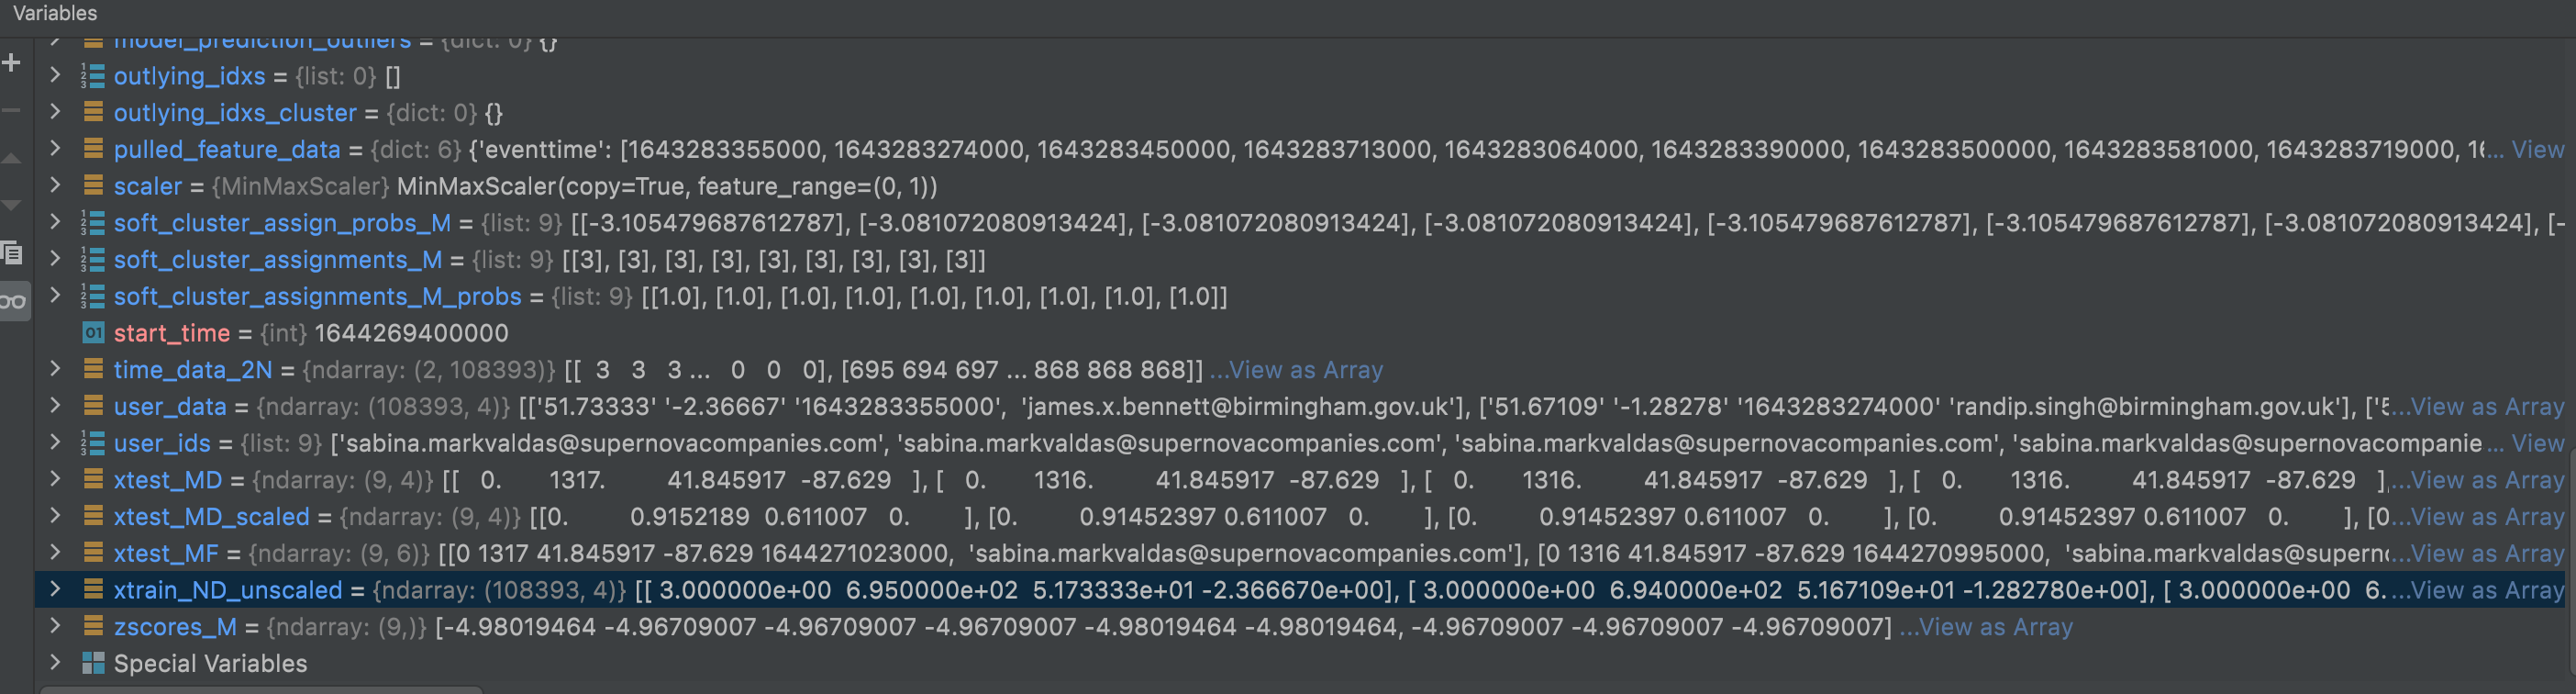

In [19]:
lat_lon_tuple = []
for i in range(len(pulled_feature_data['user_id'])):
    location = (pulled_feature_data['latitude'][i], pulled_feature_data['longitude'][i])
    lat_lon_tuple.append(location)

In [22]:
# Plot clusters
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 , tiles='cartodbpositron')
mapit_clusters = plot_clusters(normalized_verts, cluster_covs_2D, cluster_means_unscaled_2D, mapit)

# Plot feature data
counter_loc = collections.Counter(lat_lon_tuple)

for k, v in counter_loc.items():
    folium.Marker( location=[ k[0], k[1] ], 
                          popup="#Data points: " + str(v) + '<br>'
                                +"Location: " + str([k[0], k[1]]),
                         icon=folium.Icon(color="blue", icon="user")).add_to( mapit_clusters)

Cluster Id:  0
Means:  [51.92149864 -1.4732664 ]
Stds:  [0.00106701 0.00100375]
--------------------------
Cluster Id:  1
Means:  [51.89315075 -1.41320919]
Stds:  [0.00109835 0.00100704]
--------------------------
Cluster Id:  2
Means:  [51.89336268 -1.44114394]
Stds:  [0.00108566 0.00100559]
--------------------------
Cluster Id:  3
Means:  [ 41.63865452 -85.01648673]
Stds:  [0.00108574 0.00201399]
--------------------------
Cluster Id:  4
Means:  [51.94658633 -1.49119489]
Stds:  [0.00106652 0.00100306]
--------------------------
Cluster Id:  5
Means:  [51.96679256 -1.49453556]
Stds:  [0.0010727 0.0010038]
--------------------------
Cluster Id:  6
Means:  [51.87564929 -1.41899558]
Stds:  [0.00108678 0.00100794]
--------------------------
Cluster Id:  7
Means:  [51.91354021 -1.43162064]
Stds:  [0.00109469 0.00100858]
--------------------------
Cluster Id:  8
Means:  [51.95256013 -1.49101381]
Stds:  [0.00106903 0.00100351]
--------------------------
Cluster Id:  9
Means:  [26.93071873 7

In [23]:
mapit_clusters

# Current xtest (the first one). 

- (starttime: 1644269400000, endtime: 1644271200000)
- human time: February 7, 2022 9:30:00 PM -> February 7, 2022 10:00:00 PM).

In [39]:
fitted_model_id = u'model_1642896000000'

xtest_MF = np.array([[0, 1317, 41.845917, -87.629, 1644271023000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644270995000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271003000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271011000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1317, 41.845917, -87.629, 1644271021000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1317, 41.845917, -87.629, 1644271021000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271018000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271018000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271012000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

In [28]:
xtest_MF

array([[0, 1317, 41.845917, -87.629, 1644271023000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644270995000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271003000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271011000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1317, 41.845917, -87.629, 1644271021000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1317, 41.845917, -87.629, 1644271021000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271018000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271018000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1316, 41.845917, -87.629, 1644271012000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

In [32]:
xtest_MD = np.array([[   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = np.array([[0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ]])

# no outlying_idx (means no anom data point raised)

In [37]:
# retrieve sabina.markvaldas@supernovacompanies.com all feature data that used for building model. 
# Found one record. 
# Compared it manually with ES, and it's matching, "get_user2cluster_assignments" working as expected. 

In [38]:
user2cluster_assignments_map = {u'sabina.markvaldas@supernovacompanies.com': 
                                {u'model_id': u'model_1642896000000', 
                                 u'soft_clusters': [{u'max_prob': 1.0,
                                                     u'last_timestamp': 1644244088000, 
                                                     u'occurrence_in_cluster': 119, 
                                                     u'lon': -87.629, 
                                                     u'avg_prob': 1.0, 
                                                     u'cluster_id': 3, 
                                                     u'min_prob': 1.0, 
                                                     u'lat': 41.845917}], 
                                 u'user_id': u'sabina.markvaldas@supernovacompanies.com', 
                                 u'source': u'feature_data'}}

In [42]:
# xtest hit model
fitted_model = all_models_debug['model_1642896000000']
model_params = fitted_model['GMM_params']

# Prep data
feat_scales = model_params['feat_scales']
feat_mins = model_params['feat_mins']

# Rescaling test data:
scaler = MinMaxScaler()
scaler.scale_ = feat_scales
scaler.min_ = feat_mins

cluster_means = np.array(model_params["means"])
cluster_covs = np.array(model_params["covariances"])
cluster_means_2D = cluster_means[:, 2:]
cluster_covs_2D = cluster_covs[:, 2:, 2:]
cluster_means_unscaled_2D = scaler.inverse_transform(cluster_means)[:, 2:]


# Normalize clusters
cluster_verts = get_vertices_ellipse(cluster_means_2D, cluster_covs_2D, nstd=3)
normalized_verts = normalize_points(cluster_verts, scaler)

# Plot clusters
mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 , tiles='cartodbpositron')
mapit_clusters = plot_clusters(normalized_verts, cluster_covs_2D, cluster_means_unscaled_2D, mapit)

# Plot user clusters last_seen location.
for cluster in user2cluster_assignments_map['sabina.markvaldas@supernovacompanies.com']['soft_clusters']:
    folium.Marker( location=[ cluster['lat'], cluster['lon'] ], 
                          popup="#Occurence in cluster: " + str(cluster['occurrence_in_cluster']) + '<br>'
                                +"In cluster: " + str(cluster['cluster_id']),
                         icon=folium.Icon(color="blue", icon="user")).add_to( mapit_clusters)


Cluster Id:  0
Means:  [51.92149864 -1.4732664 ]
Stds:  [0.00106701 0.00100375]
--------------------------
Cluster Id:  1
Means:  [51.89315075 -1.41320919]
Stds:  [0.00109835 0.00100704]
--------------------------
Cluster Id:  2
Means:  [51.89336268 -1.44114394]
Stds:  [0.00108566 0.00100559]
--------------------------
Cluster Id:  3
Means:  [ 41.63865452 -85.01648673]
Stds:  [0.00108574 0.00201399]
--------------------------
Cluster Id:  4
Means:  [51.94658633 -1.49119489]
Stds:  [0.00106652 0.00100306]
--------------------------
Cluster Id:  5
Means:  [51.96679256 -1.49453556]
Stds:  [0.0010727 0.0010038]
--------------------------
Cluster Id:  6
Means:  [51.87564929 -1.41899558]
Stds:  [0.00108678 0.00100794]
--------------------------
Cluster Id:  7
Means:  [51.91354021 -1.43162064]
Stds:  [0.00109469 0.00100858]
--------------------------
Cluster Id:  8
Means:  [51.95256013 -1.49101381]
Stds:  [0.00106903 0.00100351]
--------------------------
Cluster Id:  9
Means:  [26.93071873 7

In [43]:
mapit_clusters

In [44]:
# run fine, no anomaly raised. Expected. 

# Xtest (2 run)
- starttime: 1644273000000, endtime: 1644274800000
- human time: February 7, 2022 10:30:00 PM -> February 7, 2022 11:00:00 PM

Q2: why we din't run between 10:00 PM -> 10:30 PM?

In [46]:
fitted_model_id = 'model_1642896000000'

In [49]:
xtest_MF = np.array([
       [0, 1377, 41.845917, -87.629, 1644274625000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1365, 41.845917, -87.629, 1644273916000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1372, 41.845917, -87.629, 1644274378000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1379, 41.845917, -87.629, 1644274796000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

xtest_MD = np.array([[   0.      , 1377.      ,   41.845917,  -87.629   ],
       [   0.      , 1365.      ,   41.845917,  -87.629   ],
       [   0.      , 1372.      ,   41.845917,  -87.629   ],
       [   0.      , 1379.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = np.array([[0.        , 0.95691452, 0.611007  , 0.        ],
       [0.        , 0.9485754 , 0.611007  , 0.        ],
       [0.        , 0.95343989, 0.611007  , 0.        ],
       [0.        , 0.95830438, 0.611007  , 0.        ]])

In [61]:
outlying_idxs = [0, 1, 2, 3]
outlying_idxs_cluster = {0: 3, 1: 3, 2: 3, 3: 3}
zscores_M = np.array([-5.82250629, -5.64522488, -5.74810315, -5.85248189])
unscaled_outlying_feat_stats = {'Unusual_Day': {'means': [2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182],
  'stddevs': [0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695]},
 'Unusual_Latitude': {'means': [41.63865452380952,
   41.63865452380952,
   41.63865452380952,
   41.63865452380952],
  'stddevs': [1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525]},
 'Unusual_Longitude': {'means': [-85.01648673469388,
   -85.01648673469388,
   -85.01648673469388,
   -85.01648673469388],
  'stddevs': [7.596064447609342,
   7.596064447609342,
   7.596064447609342,
   7.596064447609342]},
 'Unusual_Time': {'means': [1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226],
  'stddevs': [193.2071263286313,
   193.2071263286313,
   193.2071263286313,
   193.2071263286313]}}

unusual_types = ['Unusual_Day', 'Unusual_Day', 'Unusual_Day', 'Unusual_Day']
anom_feat_means = [0.417233560090703, 0.417233560090703, 0.417233560090703, 0.417233560090703]
anom_feat_stddevs = [0.13611074042227825,
 0.13611074042227825,
 0.13611074042227825,
 0.13611074042227825]

soft_cluster_assignments_M_probs = [[1.0], [1.0], [1.0], [1.0]]
soft_cluster_assignments_M = [[3], [3], [3], [3]]
cluster_assignments_M = np.array([3, 3, 3, 3])

In [52]:
# This one is strange, we have 119 cluster occurance for the same exact location. The same day of the week. 

# Max time in run_1 = 1317
# Max time in run_2 = 1379 (but raised even for 1365)


In [60]:
user2cluster_assignments_map = {u'sabina.markvaldas@supernovacompanies.com': 
                                {u'model_id': u'model_1642896000000',
                                  u'soft_clusters': [{u'avg_prob': 1.0,
                                    u'cluster_id': 3,
                                    u'last_timestamp': 1644244088000,
                                    u'lat': 41.845917,
                                    u'lon': -87.629,
                                    u'max_prob': 1.0,
                                    u'min_prob': 1.0,
                                    u'occurrence_in_cluster': 119}],
                                  u'source': u'feature_data',
                                  u'user_id': u'sabina.markvaldas@supernovacompanies.com'}}

Q3: Why are we persisting xtest assignments ? 
It will pollute user2cluster assignment in ES. New model will retrain as time goes by, and then it automatically update user2cluster assignments. 

Current debug, is overwriting cluster_assignments, as source field is passed default value (feature_data)

We should use it only for reporting without persisiting in ES. 


In [258]:
# result raised 1 event, Unusual access time, endtime: 1644274800000
# high cluster assignment probability and z-score are not correlated. Why cluster prob=1.0, but z-score -5.82 

# issue in find_outlying_idxs

# Xtest (run 3)

- starttime: 1644274800000, endtime: 1644276600000
- human time: February 7, 2022 11:00:00 PM -> February 7, 2022 11:30:00 PM

# Xtest (run 1, rerun)

In [66]:
fitted_model = all_models_debug['model_1642896000000']
model_params = fitted_model['GMM_params']

In [80]:
GMM_model, model_params_np = instantiate_model_from_ES(model_params)
feat_scales = model_params_np['feat_scales']
feat_mins = model_params_np['feat_mins']
cluster_mean_probas_K = model_params_np['cluster_mean_probas']
cluster_stddev_probas_K = model_params_np['cluster_stddev_probas']
cluster_proba_quartiles_K3 = model_params_np['cluster_proba_quartiles']
cluster_proba_skews_K = model_params_np['cluster_proba_skews']
cluster_MADs_K = model_params_np['cluster_MADs']

In [87]:
xtest_MD = np.array([[   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = np.array([[0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ]])


xtest_MD_2nd_run = np.array([
       [   0.      , 1377.      ,   41.845917,  -87.629   ],
       [   0.      , 1365.      ,   41.845917,  -87.629   ],
       [   0.      , 1372.      ,   41.845917,  -87.629   ],
       [   0.      , 1379.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled_2nd_run = np.array([
       [0.        , 0.95691452, 0.611007  , 0.        ],
       [0.        , 0.9485754 , 0.611007  , 0.        ],
       [0.        , 0.95343989, 0.611007  , 0.        ],
       [0.        , 0.95830438, 0.611007  , 0.        ]])

cluster_posterior_probas_MD = GMM_model.predict_proba(xtest_MD_scaled)
cluster_posterior_probas_MD_2nd_run = GMM_model.predict_proba(xtest_MD_scaled_2nd_run)

In [88]:
soft_cluster_assignments_M, soft_cluster_assignments_M_probs, cluster_assignments_M = assign_soft_clusters(
            cluster_posterior_probas_MD)

soft_cluster_assignments_M_2nd_run, soft_cluster_assignments_M_probs_2nd_run, cluster_assignments_M_2nd_run = assign_soft_clusters(
            cluster_posterior_probas_MD_2nd_run)

In [89]:
soft_cluster_assign_probs_M = data_soft_assign_log_likelis(xtest_MD_scaled, GMM_model.means_,
                                                                   GMM_model.covariances_, soft_cluster_assignments_M)


soft_cluster_assign_probs_M_2nd_run = data_soft_assign_log_likelis(xtest_MD_scaled_2nd_run, GMM_model.means_,
                                                                   GMM_model.covariances_, soft_cluster_assignments_M_2nd_run)

In [90]:
cluster_assign_probs_M = np.asarray([assigns[0] for assigns in soft_cluster_assign_probs_M])

cluster_assign_probs_M_2nd_run = np.asarray([assigns[0] for assigns in soft_cluster_assign_probs_M_2nd_run])

In [91]:
zscores_M, outlying_idxs, outlying_idxs_cluster = find_outlying_idxs(soft_cluster_assign_probs_M,
                                                      soft_cluster_assignments_M, cluster_mean_probas_K,
                                                      cluster_stddev_probas_K, cluster_proba_quartiles_K3,
                                                      cluster_proba_skews_K, cluster_MADs_K, zscore_thresh=-5)


zscores_M_2nd_run, outlying_idxs_2nd_run, outlying_idxs_cluster_2nd_run = find_outlying_idxs(soft_cluster_assign_probs_M_2nd_run,
                                                      soft_cluster_assignments_M_2nd_run, cluster_mean_probas_K,
                                                      cluster_stddev_probas_K, cluster_proba_quartiles_K3,
                                                      cluster_proba_skews_K, cluster_MADs_K, zscore_thresh=-5)

In [92]:
outlying_idxs

[]

In [93]:
outlying_idxs_2nd_run

[0, 1, 2, 3]

# Experiemnt with run_1 and run_2

In [208]:
fitted_model = all_models_debug['model_1642896000000']
model_params = fitted_model['GMM_params']
GMM_model, model_params_np = instantiate_model_from_ES(model_params)
feat_scales = model_params_np['feat_scales']
feat_mins = model_params_np['feat_mins']
cluster_mean_probas_K = model_params_np['cluster_mean_probas']
cluster_stddev_probas_K = model_params_np['cluster_stddev_probas']
cluster_proba_quartiles_K3 = model_params_np['cluster_proba_quartiles']
cluster_proba_skews_K = model_params_np['cluster_proba_skews']
cluster_MADs_K = model_params_np['cluster_MADs']

scaler = MinMaxScaler()
scaler.scale_ = feat_scales
scaler.min_ = feat_mins

xtest_MD = np.array([
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1317.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ],
       [   0.      , 1316.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = scaler.transform(xtest_MD)


xtest_MD_2nd_run = np.array([
       [0.0, 1377.0, 41.845917, -87.629],
       [0.0, 1317.0, 41.845917, -87.629],
       [0.0, 1317.0, 41.845917, -87.629],
       [0.0, 1317.0, 41.845917, -87.629]])

xtest_MD_scaled_2nd_run = scaler.transform(xtest_MD_2nd_run)

cluster_posterior_probas_MD = GMM_model.predict_proba(xtest_MD_scaled)
cluster_posterior_probas_MD_2nd_run = GMM_model.predict_proba(xtest_MD_scaled_2nd_run)

soft_cluster_assignments_M, soft_cluster_assignments_M_probs, cluster_assignments_M = assign_soft_clusters(
            cluster_posterior_probas_MD)

soft_cluster_assignments_M_2nd_run, soft_cluster_assignments_M_probs_2nd_run, cluster_assignments_M_2nd_run = assign_soft_clusters(
            cluster_posterior_probas_MD_2nd_run)

soft_cluster_assign_probs_M = data_soft_assign_log_likelis(xtest_MD_scaled, GMM_model.means_,
                                                                   GMM_model.covariances_, soft_cluster_assignments_M)


soft_cluster_assign_probs_M_2nd_run = data_soft_assign_log_likelis(xtest_MD_scaled_2nd_run, GMM_model.means_,
                                                                   GMM_model.covariances_, soft_cluster_assignments_M_2nd_run)

cluster_assign_probs_M = np.asarray([assigns[0] for assigns in soft_cluster_assign_probs_M])

cluster_assign_probs_M_2nd_run = np.asarray([assigns[0] for assigns in soft_cluster_assign_probs_M_2nd_run])


zscores_M, outlying_idxs, outlying_idxs_cluster = find_outlying_idxs(soft_cluster_assign_probs_M,
                                                      soft_cluster_assignments_M, cluster_mean_probas_K,
                                                      cluster_stddev_probas_K, cluster_proba_quartiles_K3,
                                                      cluster_proba_skews_K, cluster_MADs_K, zscore_thresh=-5)


zscores_M_2nd_run, outlying_idxs_2nd_run, outlying_idxs_cluster_2nd_run = find_outlying_idxs(soft_cluster_assign_probs_M_2nd_run,
                                                      soft_cluster_assignments_M_2nd_run, cluster_mean_probas_K,
                                                      cluster_stddev_probas_K, cluster_proba_quartiles_K3,
                                                      cluster_proba_skews_K, cluster_MADs_K, zscore_thresh=-5)

In [209]:
outlying_idxs

[]

In [210]:
outlying_idxs_2nd_run

[0]

In [211]:
zscores_M

array([-4.98019464, -4.96709007, -4.96709007, -4.96709007, -4.98019464,
       -4.98019464, -4.96709007, -4.96709007, -4.96709007])

In [212]:
zscores_M_2nd_run

array([-5.82250629, -4.98019464, -4.98019464, -4.98019464])

# Experiment with mahalanobis

In [213]:
from scipy.spatial import distance

In [214]:
# TARGET -> CLUSTER_3 ( target, close belonging)
# target_to_cluster_3 = distance.mahalanobis(target_lat_lon, cluster_means_2D[3], cluster_covs_2D_inv[3])
# close_to_cluster_3 = distance.mahalanobis(close_lat_lon, cluster_means_2D[3], cluster_covs_2D_inv[3])
# far_to_cluster_3 = distance.mahalanobis(far_lat_lon, cluster_means_2D[3], cluster_covs_2D_inv[3])

# print("Maholonobis dist. Target to cluster 3 (beloning): ", target_to_cluster_3, 
#       '| prob: ', cluster_posterior_probas_MD[152, 3])
# print("Maholonobis dist. Close to cluster 3 (beloning): ", close_to_cluster_3,
#       '| prob: ', cluster_posterior_probas_MD[29, 3])
# print("Maholonobis dist. Far to cluster 3 (not beloning): ", far_to_cluster_3,
#       '| prob: ', cluster_posterior_probas_MD[895, 3])
# print("---------------------------------------------------")

In [215]:
xtest_MD_scaled

array([[0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.9152189 , 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ],
       [0.        , 0.91452397, 0.611007  , 0.        ]])

In [216]:
soft_cluster_assignments_M

[[3], [3], [3], [3], [3], [3], [3], [3], [3]]

In [217]:
cluster_assignments_M

array([3, 3, 3, 3, 3, 3, 3, 3, 3])

In [218]:
cluster_means[3]

array([0.41723356, 0.83889039, 0.60660341, 0.0154347 ])

In [219]:
distance.mahalanobis(xtest_MD_scaled[0], cluster_means[3], cluster_covs[3])

0.05074748147097294

In [220]:
distance.mahalanobis(xtest_MD_scaled_2nd_run[0], cluster_means[3], cluster_covs[3])

0.04813611092650801

In [229]:
distance.mahalanobis(xtest_MD_scaled_2nd_run[0, 2:], cluster_means[3][2:], cluster_covs[3][2:, 2:])

0.0007347168369797595

In [230]:
distance.mahalanobis(xtest_MD_scaled_2nd_run[0], cluster_means[9], cluster_covs[9])

0.17503224127677555

In [231]:
distance.mahalanobis(xtest_MD_scaled_2nd_run[0, 2:], cluster_means[9][2:], cluster_covs[9][2:, 2:])

0.0809351058650718

In [236]:
scaler.inverse_transform(cluster_means)[9]

array([  3.57172995, 680.57383708,  26.93071873,  72.85655725])

In [237]:
distance.mahalanobis(xtest_MD_scaled_2nd_run[0], cluster_means[8], cluster_covs[8])

0.11216101194527235

In [241]:
for i in range(10):
    d = distance.mahalanobis(xtest_MD_scaled_2nd_run[0], cluster_means[i], cluster_covs[i])
    print("Distance from xtest[0] 2nd run to cluster: ", i, " is: ", d)

Distance from xtest[0] 2nd run to cluster:  0  is:  0.1407743624276274
Distance from xtest[0] 2nd run to cluster:  1  is:  0.10214302865492345
Distance from xtest[0] 2nd run to cluster:  2  is:  0.07463468355889917
Distance from xtest[0] 2nd run to cluster:  3  is:  0.04813611092650801
Distance from xtest[0] 2nd run to cluster:  4  is:  0.0640970358210828
Distance from xtest[0] 2nd run to cluster:  5  is:  0.08618282478912115
Distance from xtest[0] 2nd run to cluster:  6  is:  0.10308463478763305
Distance from xtest[0] 2nd run to cluster:  7  is:  0.04447195258351672
Distance from xtest[0] 2nd run to cluster:  8  is:  0.11216101194527235
Distance from xtest[0] 2nd run to cluster:  9  is:  0.17503224127677555


In [239]:
scaler.inverse_transform(cluster_means)[7]

array([   2.00000095, 1010.50398658,   51.91354021,   -1.43162064])

In [240]:
# User location in US (east coast)
# Cluster assigned : 3 (US, east coast)
# Closest cluster by mahalonbis: 7 (UK, Birmingham)
# Raised anom. 

In [242]:
for i in range(10):
    d = distance.mahalanobis(xtest_MD_scaled[0], cluster_means[i], cluster_covs[i])
    print("Distance from xtest[0] first run to cluster: ", i, " is: ", d)

Distance from xtest[0] first run to cluster:  0  is:  0.13445851008673332
Distance from xtest[0] first run to cluster:  1  is:  0.0928771009570483
Distance from xtest[0] first run to cluster:  2  is:  0.07384890666147254
Distance from xtest[0] first run to cluster:  3  is:  0.05074748147097294
Distance from xtest[0] first run to cluster:  4  is:  0.06117069111683299
Distance from xtest[0] first run to cluster:  5  is:  0.0864865198077138
Distance from xtest[0] first run to cluster:  6  is:  0.09411537392969506
Distance from xtest[0] first run to cluster:  7  is:  0.03883003438128428
Distance from xtest[0] first run to cluster:  8  is:  0.11010551562038205
Distance from xtest[0] first run to cluster:  9  is:  0.16905759490302985


In [244]:
# User location in US (Chicago)
# Cluster assigned : 3 (US, east coast, mid west)
# Closest cluster by mahalonbis: 7 (UK, Birmingham)
# Not raised anom. 

notes: just using mahalonbis distance is not deterministic. 

We can use smth like: GMM assignment, here it's cluster 3 for example. And add some mahalobis threshold. (to be determined)

In [245]:
# Let's use some mock data

In [248]:
xtest_mock = np.array([
                    [ 0.0      , 1317.0      ,   32.715736, -117.161087], # san-dego, close to cluster 3
                    [ 0.0      , 1377.0      ,   32.715736, -117.161087],
                      ])
xtest_MD_scaled_mock = scaler.transform(xtest_mock)

cluster_posterior_probas_MD_mock = GMM_model.predict_proba(xtest_MD_scaled_mock)

soft_cluster_assignments_M_mock, soft_cluster_assignments_M_probs_mock, cluster_assignments_M_mock = assign_soft_clusters(
            cluster_posterior_probas_MD_mock)


soft_cluster_assign_probs_M_mock = data_soft_assign_log_likelis(xtest_MD_scaled_mock, GMM_model.means_,
                                                                   GMM_model.covariances_, soft_cluster_assignments_M_mock)


cluster_assign_probs_M_mock = np.asarray([assigns[0] for assigns in soft_cluster_assign_probs_M_mock])



zscores_M_mock, outlying_idxs_mock, outlying_idxs_cluster_mock = find_outlying_idxs(soft_cluster_assign_probs_M_mock,
                                                      soft_cluster_assignments_M_mock, cluster_mean_probas_K,
                                                      cluster_stddev_probas_K, cluster_proba_quartiles_K3,
                                                      cluster_proba_skews_K, cluster_MADs_K, zscore_thresh=-5)


In [249]:
outlying_idxs_mock

[0, 1]

In [254]:
zscores_M_mock

array([-20.59030782, -21.09906863])

In [253]:
for i in range(10):
    d = distance.mahalanobis(xtest_MD_scaled_mock[0], cluster_means[i], cluster_covs[i])
    print("Distance from xtest_mock[0] mock run to cluster: ", i, " is: ", d)
print('Soft assignment: ',soft_cluster_assignments_M_mock[0])
print('Soft assignment prob: ',soft_cluster_assignments_M_probs_mock[0])

Distance from xtest_mock[0] mock run to cluster:  0  is:  0.13574040641571453
Distance from xtest_mock[0] mock run to cluster:  1  is:  0.09464172166905695
Distance from xtest_mock[0] mock run to cluster:  2  is:  0.07604123509787236
Distance from xtest_mock[0] mock run to cluster:  3  is:  0.05115940877463691
Distance from xtest_mock[0] mock run to cluster:  4  is:  0.06384357919160263
Distance from xtest_mock[0] mock run to cluster:  5  is:  0.08843746004374828
Distance from xtest_mock[0] mock run to cluster:  6  is:  0.0958324397570119
Distance from xtest_mock[0] mock run to cluster:  7  is:  0.04282154296974464
Distance from xtest_mock[0] mock run to cluster:  8  is:  0.11160430742487806
Distance from xtest_mock[0] mock run to cluster:  9  is:  0.1640477302562528
Soft assignment:  [3]
Soft assignment prob:  [1.0]


In [255]:
for i in range(10):
    d = distance.mahalanobis(xtest_MD_scaled_mock[1], cluster_means[i], cluster_covs[i])
    print("Distance from xtest_mock[0] mock run to cluster: ", i, " is: ", d)
print('Soft assignment: ',soft_cluster_assignments_M_mock[1])
print('Soft assignment prob: ',soft_cluster_assignments_M_probs_mock[1])

Distance from xtest_mock[0] mock run to cluster:  0  is:  0.1419998005895294
Distance from xtest_mock[0] mock run to cluster:  1  is:  0.10374670447151381
Distance from xtest_mock[0] mock run to cluster:  2  is:  0.07680324154518424
Distance from xtest_mock[0] mock run to cluster:  3  is:  0.04884589363764826
Distance from xtest_mock[0] mock run to cluster:  4  is:  0.06665320990873685
Distance from xtest_mock[0] mock run to cluster:  5  is:  0.08814044784996575
Distance from xtest_mock[0] mock run to cluster:  6  is:  0.10464918993085494
Distance from xtest_mock[0] mock run to cluster:  7  is:  0.047972391424633255
Distance from xtest_mock[0] mock run to cluster:  8  is:  0.11363239285522414
Distance from xtest_mock[0] mock run to cluster:  9  is:  0.16999010268991857
Soft assignment:  [3]
Soft assignment prob:  [1.0]


Using prob + mahalonbis is also, non deterministic, meaning if we used we prob+mahalonobis, we would assign xtest mock to cluster 7 (UK, Birmingham). 


I think z-score is fine. The issue with unusual time. Solution - use more relaxed sigma (7 stds) on time. 

# Contunie debug, Xtest run = 3

- starttime: 1644274800000, endtime: 1644276600000
- human time: February 7, 2022 11:00:00 PM -> February 7, 2022 11:30:00 PM

In [264]:
fitted_model_id = u'model_1642896000000'

xtest_MF = np.array([
       [0, 1381, 41.845917, -87.629, 1644274916000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1388, 41.845917, -87.629, 1644275332000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1389, 41.845917, -87.629, 1644275375000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1388, 41.845917, -87.629, 1644275332000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

xtest_MD = np.array([
       [   0.      , 1381.      ,   41.845917,  -87.629   ],
       [   0.      , 1388.      ,   41.845917,  -87.629   ],
       [   0.      , 1389.      ,   41.845917,  -87.629   ],
       [   0.      , 1388.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = np.array([
       [0.        , 0.95969423, 0.611007  , 0.        ],
       [0.        , 0.96455872, 0.611007  , 0.        ],
       [0.        , 0.96525365, 0.611007  , 0.        ],
       [0.        , 0.96455872, 0.611007  , 0.        ]])

outlying_idxs = [0, 1, 2, 3]
outlying_idxs_cluster = {0: 3, 1: 3, 2: 3, 3: 3}
soft_cluster_assignments_M =  [[3], [3], [3], [3]]
soft_cluster_assignments_M_probs = [[1.0], [1.0], [1.0], [1.0]]
zscores_M = np.array([-5.88257999, -5.9888879 , -6.00419724, -5.9888879 ])
unscaled_outlying_feat_stats = {'Unusual_Day': {'means': [2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182],
  'stddevs': [0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695]},
 'Unusual_Latitude': {'means': [41.63865452380952,
   41.63865452380952,
   41.63865452380952,
   41.63865452380952],
  'stddevs': [1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525]},
 'Unusual_Longitude': {'means': [-85.01648673469388,
   -85.01648673469388,
   -85.01648673469388,
   -85.01648673469388],
  'stddevs': [7.596064447609342,
   7.596064447609342,
   7.596064447609342,
   7.596064447609342]},
 'Unusual_Time': {'means': [1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226],
  'stddevs': [193.2071263286313,
   193.2071263286313,
   193.2071263286313,
   193.2071263286313]}}

anom_types = ['Unusual_Day', 'Unusual_Day', 'Unusual_Day', 'Unusual_Day']
cluster_assignments_M = np.array([3, 3, 3, 3])

In [265]:
# result generated event, but did not write to ES, because it caught condition of "aggregate_similar_events". 
# Expected

# Xtest run = 4

- starttime: 1644276600000, endtime: 1644278400000
- human time: February 7, 2022 11:30:00 PM -> February 8, 2022 12:00:00 AM

In [266]:
fitted_model_id = u'model_1642896000000'
xtest_MF = np.array([[0, 1114, 41.845917, -87.629, 1644276898000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1115, 41.845917, -87.629, 1644276957000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1114, 41.845917, -87.629, 1644276899000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1117, 41.845917, -87.629, 1644277025000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1116, 41.845917, -87.629, 1644277017000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1114, 41.845917, -87.629, 1644276852000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1129, 41.845917, -87.629, 1644277745000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1117, 41.845917, -87.629, 1644277025000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1128, 41.845917, -87.629, 1644277739000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1117, 41.845917, -87.629, 1644277027000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1114, 41.845917, -87.629, 1644276852000,
        'sabina.markvaldas@supernovacompanies.com'],
       [0, 1117, 41.845917, -87.629, 1644277028000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

xtest_MD = np.array([[   0.      , 1114.      ,   41.845917,  -87.629   ],
       [   0.      , 1115.      ,   41.845917,  -87.629   ],
       [   0.      , 1114.      ,   41.845917,  -87.629   ],
       [   0.      , 1117.      ,   41.845917,  -87.629   ],
       [   0.      , 1116.      ,   41.845917,  -87.629   ],
       [   0.      , 1114.      ,   41.845917,  -87.629   ],
       [   0.      , 1129.      ,   41.845917,  -87.629   ],
       [   0.      , 1117.      ,   41.845917,  -87.629   ],
       [   0.      , 1128.      ,   41.845917,  -87.629   ],
       [   0.      , 1117.      ,   41.845917,  -87.629   ],
       [   0.      , 1114.      ,   41.845917,  -87.629   ],
       [   0.      , 1117.      ,   41.845917,  -87.629   ]])

xtest_MD_scaled = np.array([[0.        , 0.77414871, 0.611007  , 0.        ],
       [0.        , 0.77484364, 0.611007  , 0.        ],
       [0.        , 0.77414871, 0.611007  , 0.        ],
       [0.        , 0.7762335 , 0.611007  , 0.        ],
       [0.        , 0.77553857, 0.611007  , 0.        ],
       [0.        , 0.77414871, 0.611007  , 0.        ],
       [0.        , 0.78457262, 0.611007  , 0.        ],
       [0.        , 0.7762335 , 0.611007  , 0.        ],
       [0.        , 0.78387769, 0.611007  , 0.        ],
       [0.        , 0.7762335 , 0.611007  , 0.        ],
       [0.        , 0.77414871, 0.611007  , 0.        ],
       [0.        , 0.7762335 , 0.611007  , 0.        ]])

outlying_idxs = []
outlying_idxs_cluster = {}
soft_cluster_assignments_M = [[3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3], [3]]
soft_cluster_assignments_M_probs = [[1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0]]

zscores_M = np.array([-2.9478072 , -2.95472616, -2.9478072 , -2.96865594, -2.96167574,
       -2.9478072 , -3.05480687, -2.96865594, -3.04745921, -2.96865594,
       -2.9478072 , -2.96865594])

unscaled_outlying_feat_stats = {'Unusual_Day': {'means': [], 'stddevs': []},
 'Unusual_Latitude': {'means': [], 'stddevs': []},
 'Unusual_Longitude': {'means': [], 'stddevs': []},
 'Unusual_Time': {'means': [], 'stddevs': []}}

anom_types = []


In [267]:
# Result.Did not raise anom event. As z scores is lowwer than -5 stds. Expected. OK

# Xtest run = 5

- starttime: 1644278400000, endtime: 1644280200000
- human time:  February 8, 2022 12:00:00 AM -> February 8, 2022 12:30:00 AM

In [268]:
fitted_model_id = u'model_1642896000000'
xtest_MF = np.array([[1, 12, 41.845917, -87.629, 1644279177000,
        'sabina.markvaldas@supernovacompanies.com'],
       [1, 12, 41.845917, -87.629, 1644279177000,
        'sabina.markvaldas@supernovacompanies.com'],
       [1, 14, 41.845917, -87.629, 1644279242000,
        'sabina.markvaldas@supernovacompanies.com'],
       [1, 14, 41.845917, -87.629, 1644279242000,
        'sabina.markvaldas@supernovacompanies.com']], dtype=object)

xtest_MD = np.array([[  1.      ,  12.      ,  41.845917, -87.629   ],
       [  1.      ,  12.      ,  41.845917, -87.629   ],
       [  1.      ,  14.      ,  41.845917, -87.629   ],
       [  1.      ,  14.      ,  41.845917, -87.629   ]])

xtest_MD_scaled = np.array([[0.16666667, 0.00833912, 0.611007  , 0.        ],
       [0.16666667, 0.00833912, 0.611007  , 0.        ],
       [0.16666667, 0.00972898, 0.611007  , 0.        ],
       [0.16666667, 0.00972898, 0.611007  , 0.        ]])

outlying_idxs = [0, 1, 2, 3]
outlying_idxs_cluster = {0: 3, 1: 3, 2: 3, 3: 3}
soft_cluster_assignments_M =  [[3], [3], [3], [3]]
soft_cluster_assignments_M_probs = [[1.0], [1.0], [1.0], [1.0]]
zscores_M = np.array([-16.17803262, -16.17803262, -16.11603618, -16.11603618])
unscaled_outlying_feat_stats = {'Unusual_Day': {'means': [2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182,
   2.5034013605442182],
  'stddevs': [0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695,
   0.8166644425336695]},
 'Unusual_Latitude': {'means': [41.63865452380952,
   41.63865452380952,
   41.63865452380952,
   41.63865452380952],
  'stddevs': [1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525,
   1.5508747912252525]},
 'Unusual_Longitude': {'means': [-85.01648673469388,
   -85.01648673469388,
   -85.01648673469388,
   -85.01648673469388],
  'stddevs': [7.596064447609342,
   7.596064447609342,
   7.596064447609342,
   7.596064447609342]},
 'Unusual_Time': {'means': [1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226,
   1207.1632653061226],
  'stddevs': [193.2071263286313,
   193.2071263286313,
   193.2071263286313,
   193.2071263286313]}}

anom_types = ['Unusual_Time', 'Unusual_Time', 'Unusual_Time', 'Unusual_Time']
similar_to_hist = False # Why False because triggering feature is different. (in history: Day of the week, 
# current one is Time of the day). Second xtest it was True, because in the first xtest if was False. 

Result triggered 1 anom event for the that user (sabina), as z_score is -16, and trigerring feature is Time of the day. Expected. Deffinetly need to adjust time feature as it's too sensistive. User located on the same location in the cluster for 119 time, and logged at night and triggered anomaly  

# Fast forwarding Xtest for 'sabina.markvaldas@supernovacompanies.com (run=6)

Triggered anom event, as zscore is -15. This anom event (Unusual time) is only 30 min later from above triggered one. The only difference in the  run=5 xtest time_of_the_day = 12, while run=6, time_of_the_day = 44. Meaning "aggregate_similar_events" is not working for the anom evennts with close Time values.

# Fast forwarding Xtest for 'sabina.markvaldas@supernovacompanies.com  untill anom  will be trigerred. 

Finished model. Triggered 3 anoms, and only for sabine

# Notes collection:

1. Run dev version produced 10K anom events, prod (56 events)
2. Run branch version also produces 4-5K events. 


3. Running with debug mode. Find interesting things. 
    1. Sometimes GMM might result like these ellipses:
    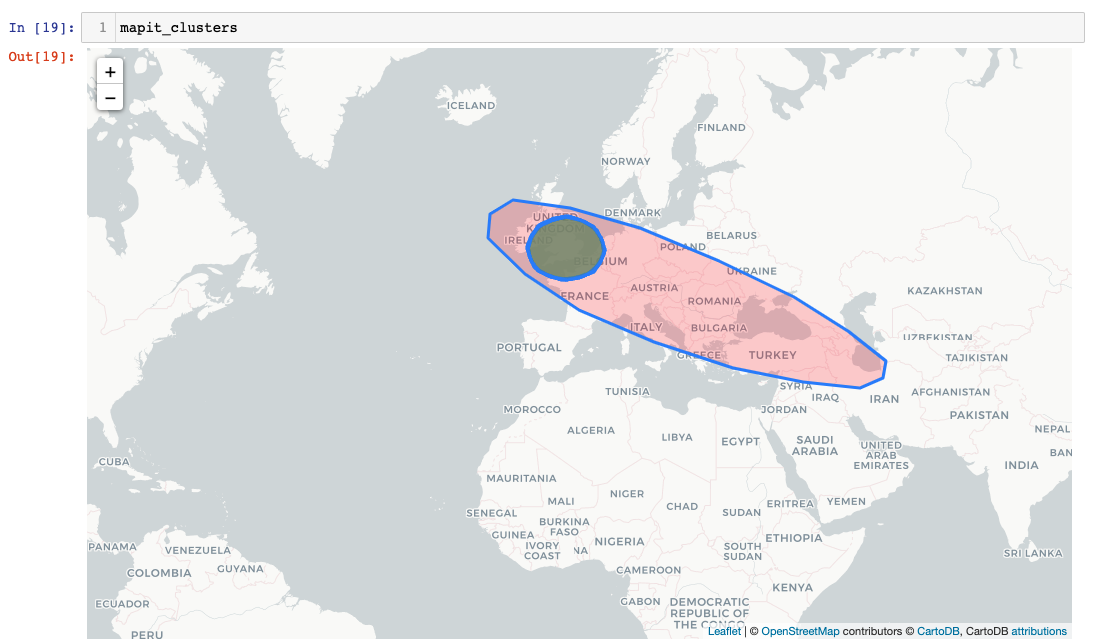]
    
    2. Sometimes it's normal (most of the time). 
    

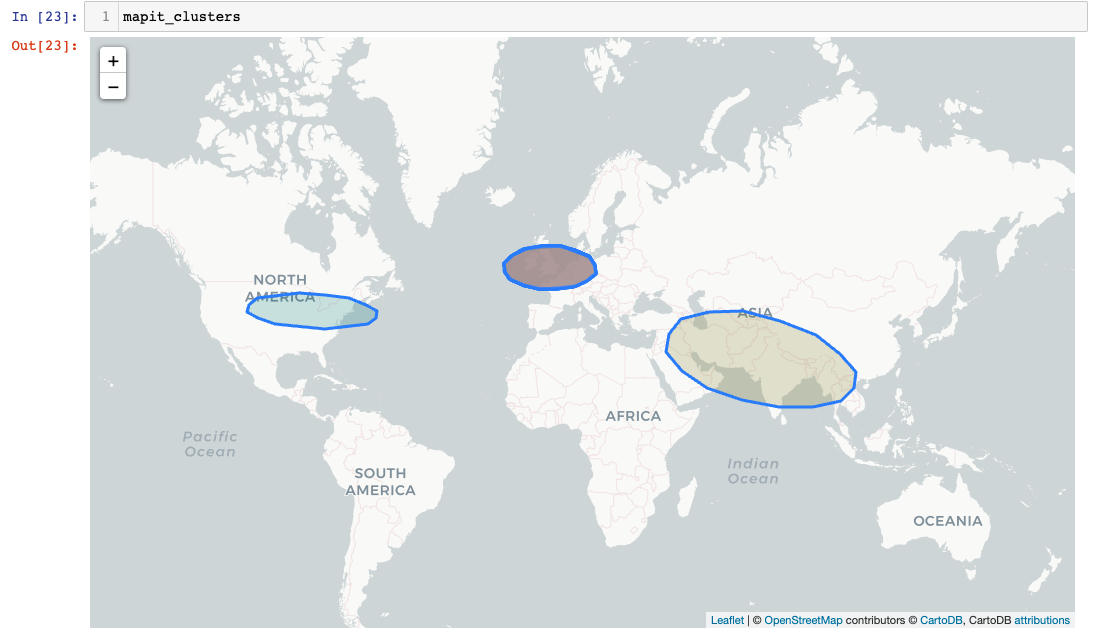